<a href="https://colab.research.google.com/github/LovingChester/mlportfolio/blob/main/BeijingPM2_5_mltask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Beijing PM2.5 data ML task
This notebook intends to perform some machine learning task, such as regression, classification, clustering, on the Beijing PM2.5 dataset. The dataset is provided by https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns

#### Read Dataset

In [ ]:
PRSA_df = pd.read_csv('drive/MyDrive/ML_dataset/PRSA_data_2010.1.1-2014.12.31.csv')
PRSA_df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


#### EDA

In [ ]:
PRSA_df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [ ]:
PRSA_df.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

We have to first deal with the null value first. Given it is a time-series dataset, we can do interpolate.

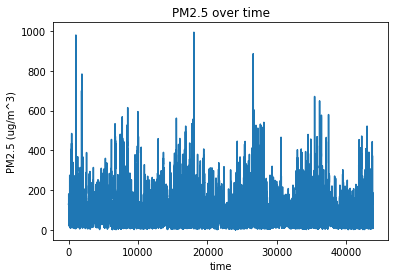

In [ ]:
PRSA_df['pm2.5'] = PRSA_df['pm2.5'].interpolate(method='linear', 
                                                limit_direction='both', 
                                                axis=0)
plt.title('PM2.5 over time')
plt.xlabel('time')
plt.ylabel('PM2.5 (ug/m^3)')
plt.plot(PRSA_df['pm2.5'])
plt.show()

Plot the distribution for each attribute. We can ignore the first 5 attribute, since they are just row number and time.

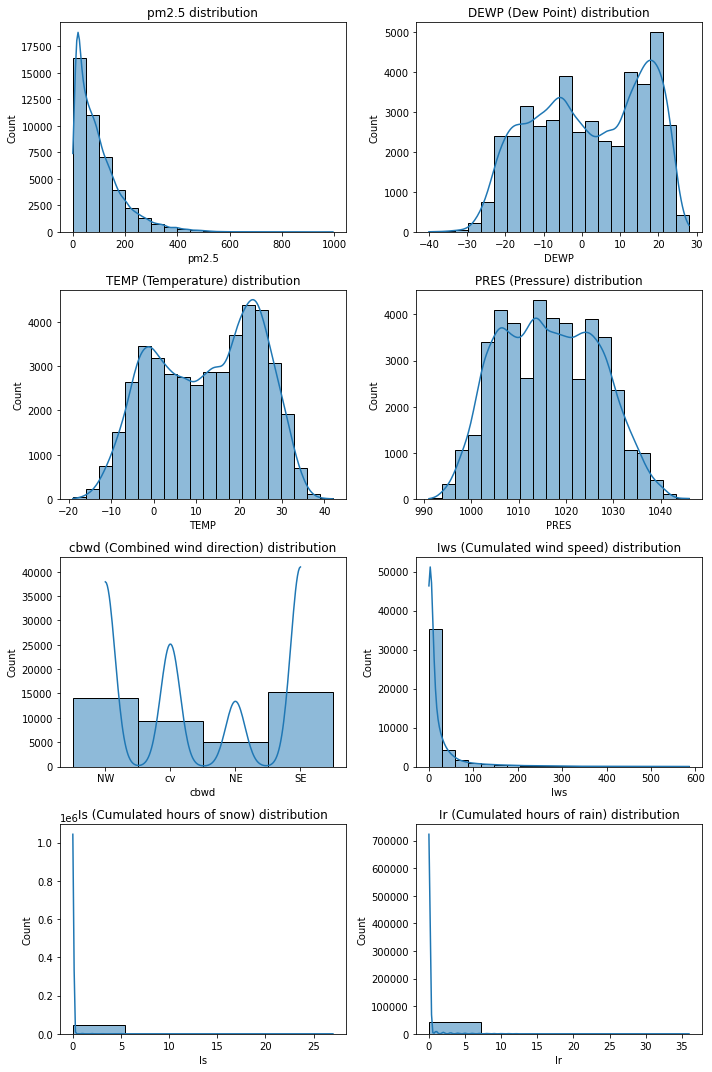

In [ ]:
fig = plt.figure(figsize=(10, 15), tight_layout=True)

plt.subplot(421)
plt.title('pm2.5 distribution')
sns.histplot(PRSA_df['pm2.5'], kde=True, bins=20)

plt.subplot(422)
plt.title('DEWP (Dew Point) distribution')
sns.histplot(PRSA_df['DEWP'], kde=True, bins=20)

plt.subplot(423)
plt.title('TEMP (Temperature) distribution')
sns.histplot(PRSA_df['TEMP'], kde=True, bins=20)

plt.subplot(424)
plt.title('PRES (Pressure) distribution')
sns.histplot(PRSA_df['PRES'], kde=True, bins=20)

plt.subplot(425)
plt.title('cbwd (Combined wind direction) distribution')
sns.histplot(PRSA_df['cbwd'], kde=True, bins=20)

plt.subplot(426)
plt.title('Iws (Cumulated wind speed) distribution')
sns.histplot(PRSA_df['Iws'], kde=True, bins=20)

plt.subplot(427)
plt.title('Is (Cumulated hours of snow) distribution')
sns.histplot(PRSA_df['Is'], kde=True, bins=5)

plt.subplot(428)
plt.title('Ir (Cumulated hours of rain) distribution')
sns.histplot(PRSA_df['Ir'], kde=True, bins=5)

plt.show()

#### Correlation Heatmap

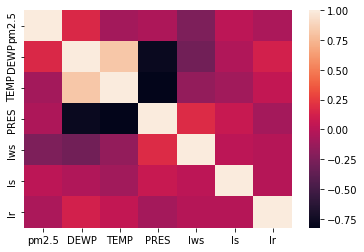

In [ ]:
sns.heatmap(PRSA_df.iloc[:, 5:].corr())
plt.show()

#### Feature Selection
We will try Random Forest to select the feature, as the algorithm will automatically calaulate the importance of each feature.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

PRSA_df_d = PRSA_df.drop(['No', 'year', 'month', 'day', 'hour', 'cbwd'], axis=1)

RF = RandomForestRegressor(random_state=1, max_depth=10)
sfm = SelectFromModel(RF)
feature = sfm.fit_transform(PRSA_df_d.iloc[:, 1:], PRSA_df_d['pm2.5'])
feature

array([[-21.  , -11.  ,   1.79],
       [-21.  , -12.  ,   4.92],
       [-21.  , -11.  ,   6.71],
       ...,
       [-22.  ,  -3.  , 242.7 ],
       [-22.  ,  -4.  , 246.72],
       [-21.  ,  -3.  , 249.85]])

#### GRU to perform time series regression

In [ ]:
class GRU(nn.Module):
    def __init__(self, in_dim, gru_hidden_dim, mlp_hidden_dim, out_dim=1):

        super(GRU, self).__init__()

        self.gru = nn.GRU(input_size=in_dim, hidden_size=gru_hidden_dim,
                            batch_first=True)
        
        self.fc1 = nn.Linear(gru_hidden_dim, mlp_hidden_dim)

        self.dp = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(mlp_hidden_dim, out_dim)
        
    def forward(self, x):

        output, gru_h = self.gru(x)

        x = F.relu(self.fc1(gru_h[0]))

        x = self.dp(x)

        x = self.fc2(x)

        return x

Dataset class

In [ ]:
from torch.utils.data import Dataset

class PRSA_Dataset(Dataset):
    def __init__(self, X, y, seq_len):
        
        super(PRSA_Dataset, self).__init__()
        
        self.X = []
        self.y = []

        for i in range(len(X)-seq_len):
            self.X.append(X[i:(i+seq_len)])
            self.y.append(y[i+seq_len])

        self.X = torch.tensor(np.array(self.X), dtype=torch.float)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda:0


Set up Training

In [ ]:
in_dim = feature.shape[1]
gru_hidden_dim = 8
mlp_hidden_dim = 16
learning_rate = 0.01
seq_len = 5
# model = GRU(in_dim, gru_hidden_dim, mlp_hidden_dim)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 200

#model = model.to(device)
#model.train()

Training Function

In [ ]:
def train(train_loader):
    final_loss = None
    for epoch in tqdm(range(1, epochs + 1)):
        sum_loss = 0.
        for batch_idx, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            output = model(X)

            loss = F.mse_loss(output, y)

            sum_loss += loss.item()

            loss.backward()
            optimizer.step()

        sum_loss /= len(train_loader)
        # if epoch % 100 == 0:
        #     print(f'Epoch: {epoch}, Loss: {sum_loss:.3f}')
        
        final_loss = sum_loss
        
    #print(f'Loss: {final_loss:.3f}')

    return

Validation and Testing Function

In [ ]:
from sklearn.metrics import r2_score
def valid_test(data_loader, model):
    loss = 0
    true = []
    pred = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)

            output = model(X)

            #r2 += r2_score(y.cpu().detach().numpy(), output.cpu().detach().numpy())
            true.extend(y.cpu().detach().tolist())
            pred.extend(output.cpu().detach().tolist())
            loss += torch.sqrt(F.mse_loss(output, y))

        loss /= len(data_loader)
        
    return loss, true, pred

#### Training and validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = np.concatenate((feature, PRSA_df_d['pm2.5'].to_numpy().reshape((-1, 1))),
                      axis=1)

# apply standard scaler
ss_scaler = StandardScaler()
data = ss_scaler.fit_transform(data)

# apply min max scaler
# mm_scaler = MinMaxScaler(feature_range=(-1, 1))
# data = mm_scaler.fit_transform(data)

X = data[:, 0:-1]
y = data[:, -1:]

# Use rest of the data for training and validation
# X_train_valid = X[:int(len(X)*0.9)]
# y_train_valid = y[:int(len(X)*0.9)]

X_train = X[:int(len(X)*0.7)]
y_train = y[:int(len(X)*0.7)]
dataset_train = PRSA_Dataset(X_train, y_train, seq_len)
train_loader = du.DataLoader(dataset=dataset_train,
                            batch_size=200, shuffle=True)

X_valid = X[int(len(X)*0.7):int(len(X)*0.9)]
y_valid = y[int(len(X)*0.7):int(len(X)*0.9)]
dataset_valid = PRSA_Dataset(X_valid, y_valid, seq_len)
valid_loader = du.DataLoader(dataset=dataset_valid,
                                batch_size=200, shuffle=True)

# Use 10% of data for test
X_test = X[int(len(X)*0.9):]
y_test = y[int(len(X)*0.9):]
dataset_test = PRSA_Dataset(X_test, y_test, seq_len)
test_loader = du.DataLoader(dataset=dataset_test,
                             batch_size=200, shuffle=False)

losses = []
models = []
# Repeat the training and validation for this much time
repeat = 100
for i in range(repeat):
    model = GRU(in_dim, gru_hidden_dim, mlp_hidden_dim)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    train(train_loader)

    model.eval()
    loss, true, pred = valid_test(valid_loader, model)
    losses.append(float(loss.cpu().detach()))
    print(f'Trial {i+1}, RMSE loss: {loss:.3f}')

    models.append(model)
    
    # for layer in model.children():
    #     if hasattr(layer, 'reset_parameters'):
    #         layer.reset_parameters()

100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 1, RMSE loss: 0.802


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 2, RMSE loss: 0.794


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 3, RMSE loss: 0.809


100%|██████████| 200/200 [02:02<00:00,  1.64it/s]


Trial 4, RMSE loss: 0.812


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 5, RMSE loss: 0.799


100%|██████████| 200/200 [02:02<00:00,  1.64it/s]


Trial 6, RMSE loss: 0.810


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 7, RMSE loss: 0.801


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 8, RMSE loss: 0.804


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Trial 9, RMSE loss: 0.812


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Trial 10, RMSE loss: 0.788


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Trial 11, RMSE loss: 0.813


100%|██████████| 200/200 [02:00<00:00,  1.65it/s]


Trial 12, RMSE loss: 0.815


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 13, RMSE loss: 0.779


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 14, RMSE loss: 0.797


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 15, RMSE loss: 0.800


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 16, RMSE loss: 0.792


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 17, RMSE loss: 0.788


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 18, RMSE loss: 0.800


100%|██████████| 200/200 [02:00<00:00,  1.65it/s]


Trial 19, RMSE loss: 0.783


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 20, RMSE loss: 0.785


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Trial 21, RMSE loss: 0.798


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 22, RMSE loss: 0.792


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 23, RMSE loss: 0.793


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 24, RMSE loss: 0.782


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 25, RMSE loss: 0.794


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 26, RMSE loss: 0.806


100%|██████████| 200/200 [02:00<00:00,  1.65it/s]


Trial 27, RMSE loss: 0.788


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 28, RMSE loss: 0.800


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 29, RMSE loss: 0.791


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 30, RMSE loss: 0.798


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 31, RMSE loss: 0.795


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 32, RMSE loss: 0.795


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 33, RMSE loss: 0.802


100%|██████████| 200/200 [02:00<00:00,  1.67it/s]


Trial 34, RMSE loss: 0.780


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 35, RMSE loss: 0.805


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 36, RMSE loss: 0.796


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 37, RMSE loss: 0.796


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 38, RMSE loss: 0.800


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 39, RMSE loss: 0.800


100%|██████████| 200/200 [02:00<00:00,  1.67it/s]


Trial 40, RMSE loss: 0.788


100%|██████████| 200/200 [02:00<00:00,  1.67it/s]


Trial 41, RMSE loss: 0.802


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


Trial 42, RMSE loss: 0.798


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


Trial 43, RMSE loss: 0.808


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 44, RMSE loss: 0.813


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 45, RMSE loss: 0.795


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 46, RMSE loss: 0.785


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 47, RMSE loss: 0.786


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 48, RMSE loss: 0.813


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 49, RMSE loss: 0.798


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


Trial 50, RMSE loss: 0.797


100%|██████████| 200/200 [02:00<00:00,  1.65it/s]


Trial 51, RMSE loss: 0.786


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 52, RMSE loss: 0.818


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 53, RMSE loss: 0.796


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 54, RMSE loss: 0.815


100%|██████████| 200/200 [02:03<00:00,  1.63it/s]


Trial 55, RMSE loss: 0.794


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 56, RMSE loss: 0.815


100%|██████████| 200/200 [02:03<00:00,  1.61it/s]


Trial 57, RMSE loss: 0.801


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 58, RMSE loss: 0.793


100%|██████████| 200/200 [02:03<00:00,  1.61it/s]


Trial 59, RMSE loss: 0.806


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 60, RMSE loss: 0.799


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 61, RMSE loss: 0.791


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 62, RMSE loss: 0.803


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 63, RMSE loss: 0.797


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 64, RMSE loss: 0.800


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 65, RMSE loss: 0.800


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 66, RMSE loss: 0.777


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 67, RMSE loss: 0.812


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 68, RMSE loss: 0.812


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 69, RMSE loss: 0.800


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 70, RMSE loss: 0.791


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 71, RMSE loss: 0.815


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 72, RMSE loss: 0.802


100%|██████████| 200/200 [02:03<00:00,  1.63it/s]


Trial 73, RMSE loss: 0.798


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 74, RMSE loss: 0.812


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 75, RMSE loss: 0.806


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 76, RMSE loss: 0.790


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 77, RMSE loss: 0.810


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 78, RMSE loss: 0.794


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 79, RMSE loss: 0.798


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 80, RMSE loss: 0.787


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 81, RMSE loss: 0.790


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 82, RMSE loss: 0.800


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


Trial 83, RMSE loss: 0.813


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


Trial 84, RMSE loss: 0.797


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 85, RMSE loss: 0.803


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 86, RMSE loss: 0.797


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


Trial 87, RMSE loss: 0.795


100%|██████████| 200/200 [02:03<00:00,  1.63it/s]


Trial 88, RMSE loss: 0.803


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 89, RMSE loss: 0.804


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 90, RMSE loss: 0.798


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 91, RMSE loss: 0.796


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 92, RMSE loss: 0.783


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 93, RMSE loss: 0.800


100%|██████████| 200/200 [02:03<00:00,  1.63it/s]


Trial 94, RMSE loss: 0.815


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 95, RMSE loss: 0.784


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 96, RMSE loss: 0.806


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 97, RMSE loss: 0.796


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Trial 98, RMSE loss: 0.798


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Trial 99, RMSE loss: 0.788


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]

Trial 100, RMSE loss: 0.801


##### Validation Error Distribution

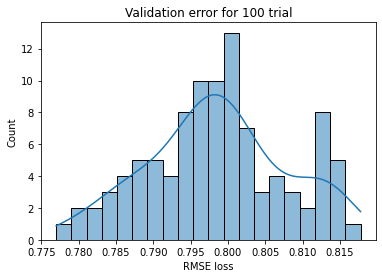

In [ ]:
plt.title('Validation error for 100 trial')
plt.xlabel('RMSE loss')
sns.histplot(losses, kde=True, bins=20)

In [ ]:
pd.DataFrame(losses).describe()

,0
count,100.000000
mean,0.798575
std,0.009264
min,0.776983
25%,0.792747
50%,0.798152
75%,0.803947
max,0.817760


#### Testing

In [ ]:
preds = np.zeros((len(X_test)-seq_len, 1))
for model in models:
    loss, true, pred = valid_test(test_loader, model)
    preds += pred

preds /= repeat

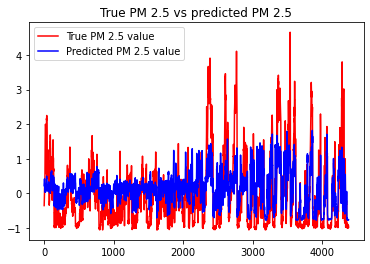

In [ ]:
plt.title('True PM 2.5 vs predicted PM 2.5')
plt.plot(true, c='r', label='True PM 2.5 value')
plt.plot(preds, c='b', label='Predicted PM 2.5 value')
plt.legend()
plt.show()